# 🚀 Customize and Deploy `Qwen/Qwen2-Audio-7B-Instruct` on Amazon SageMaker AI
---
In this notebook, we explore **Qwen2-Audio-7B-Instruct**, a 7-billion-parameter audio-language model from Alibaba’s Qwen2-Audio series. You’ll learn how to fine-tune it (or use it out-of-the-box), evaluate its audio + text understanding, and deploy it using SageMaker for voice interaction, audio analysis, and multimodal workflows.

**What is Qwen2-Audio-7B-Instruct?**

Qwen2-Audio-7B-Instruct is the instruction-tuned variant of the Qwen2-Audio-7B model. It can take **audio inputs** (speech, other sound signals) and **text instructions** to perform tasks such as transcription, translation, conversational voice chat, audio analysis, and sound-event detection. It supports two primary audio interaction modes: *voice chat* (audio in, audio/text out conversationally) and *audio analysis* (audio + text instructions to analyze or respond). It is released under the **Apache-2.0 license**.  
🔗 Model card: [Qwen/Qwen2-Audio-7B-Instruct on Hugging Face](https://huggingface.co/Qwen/Qwen2-Audio-7B-Instruct)

---

**Key Specifications**

| Feature | Details |
|---|---|
| **Parameters** | ~7 billion |
| **Modalities** | Audio input + Text input → Text output |
| **Interaction Modes** | Voice chat; Audio analysis (audio + instruction) |
| **Context / Window Length** | ~32,768 tokens for text; audio input support for various sampling rates |
| **Languages Supported** | English and Chinese (at minimum) |
| **License** | Apache-2.0 |

---

**Benchmarks & Behavior**

- Qwen2-Audio has been evaluated across tasks like automatic speech recognition (ASR), speech-to-text translation, emotion recognition, and sound event classification, showing state-of-the-art or competitive performance.  
- It is designed to understand complex audio environments (multi-speaker or noisy input) and respond appropriately to natural instructions.  
- Strong fit for applications in **multilingual speech agents, customer service bots, transcription services, and audio analytics pipelines**.  

---

**Using This Notebook**

Here’s what you’ll cover:

* Load a sample dataset from Hugging Face and prepare it for fine-tuning  
* Fine-tune with SageMaker Training Jobs  
* Run Model Evaluation  
* Deploy to SageMaker Endpoints  

---

Let’s begin by loading `Qwen/Qwen2-Audio-7B-Instruct` and running sample voice and audio-analysis prompts to observe baseline behavior.


In [1]:
%pip install -Uq sagemaker datasets

/home/ubuntu/pranavvm/py312-training/bin/python3: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml


In [3]:
region = boto3.Session().region_name

sess = sagemaker.Session(boto3.Session(region_name=region))

sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 region = boto3.Session().region_name                                                        │
│    2                                                                                             │
│ ❱  3 sess = sagemaker.Session(boto3.Session(region_name=region))                                 │
│    4                                                                                             │
│    5 sagemaker_session_bucket = None                                                             │
│    6 if sagemaker_session_bucket is None and sess is not None:                                   │
│                                                                                                  │
│ /home/ubuntu/pranavvm/py312-training/lib/python3.12/site-packages/sagemaker/session.py:265 in    │
│ __init__                                                                                         │
│                                                                                                  │
│    262 │   │   self.lambda_client = None                                                         │
│    263 │   │   self.settings = settings if settings else SessionSettings()                       │
│    264 │   │                                                                                     │
│ ❱  265 │   │   self._initialize(                                                                 │
│    266 │   │   │   boto_session=boto_session,                                                    │
│    267 │   │   │   sagemaker_client=sagemaker_client,                                            │
│    268 │   │   │   sagemaker_runtime_client=sagemaker_runtime_client,                            │
│                                                                                                  │
│ /home/ubuntu/pranavvm/py312-training/lib/python3.12/site-packages/sagemaker/session.py:293 in    │
│ _initialize                                                                                      │
│                                                                                                  │
│    290 │   │                                                                                     │
│    291 │   │   self._region_name = self.boto_session.region_name                                 │
│    292 │   │   if self._region_name is None:                                                     │
│ ❱  293 │   │   │   raise ValueError(                                                             │
│    294 │   │   │   │   "Must setup local AWS configuration with a region supported by SageMaker  │
│    295 │   │   │   )                                                                             │
│    296                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Must setup local AWS configuration with a region supported by SageMaker.

In [4]:
print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 print(f"sagemaker role arn: {role}")                                                         │
│   2 print(f"sagemaker bucket: {sess.default_bucket()}")                                          │
│   3 print(f"sagemaker session region: {sess.boto_region_name}")                                  │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'role' is not defined

## Data Preparation for Supervised Fine-tuning

### [AudioSet-Audio-Instructions](https://huggingface.co/datasets/mesolitica/AudioSet-Audio-Instructions)

**AudioSet-Audio-Instructions** is a multimodal dataset created by pairing **Google AudioSet audio clips** with human-written instruction–response examples. It is designed to support **instruction tuning for audio understanding** tasks such as event detection, audio classification, and acoustic reasoning.

**Data Format & Structure**:
- Built on **AudioSet**, a large ontology of over 500 audio event classes.  
- Each example contains:  
  • `audio` — a 10-second audio clip from AudioSet.  
  • `instruction` — a natural language prompt about the audio (e.g., “Identify the main sound in this clip”).  
  • `response` — the assistant’s answer (e.g., “This audio contains the sound of a violin being played”).  
- Distributed in **JSON/Parquet** formats for ease of use.  
- Includes `train`, `validation`, and `test` splits.  

**License**: Same as **AudioSet** (Creative Commons Attribution license) with additional generated annotations shared openly for research.  

**Applications**:

The dataset is useful for training and evaluating multimodal models on:  
- Audio event classification and tagging  
- Instruction-following tasks for sound and acoustic scenes  
- Building conversational audio assistants  
- Enhancing models for **multimodal reasoning** (sound + text)  

---

*This dataset bridges raw audio perception with natural language supervision, making it a valuable resource for instruction-tuned audio understanding models.*  


In [2]:
import os
import json
import pprint
from tqdm import tqdm
import soundfile as sf
from datasets import load_dataset, Audio

**Preparing Your Dataset in `messages` format**

This section walks you through creating a conversation-style dataset—the required `messages` format—for directly training LLMs using SageMaker AI.

**What Is the `messages` Format?**

The `messages` format structures instances as chat-like exchanges, wrapping each conversation turn into a role-labeled JSON array. It’s widely used by frameworks like TRL.

Example entry:

```json
{
  "messages": [
    { "role": "system", "content": "You are a helpful assistant." },
    { "role": "user", "content": "How do I bake sourdough?" },
    { "role": "assistant", "content": "First, you need to create a starter by..." }
  ]
}


In [14]:
dataset_name = "mesolitica/AudioSet-Audio-Instructions"
dataset = load_dataset(dataset_name, split="500k_part1_speech[:1000]") 
dataset = dataset.cast_column("audio_filename", Audio(sampling_rate=16000))

In [15]:
dataset_parent_path = os.path.join(os.getcwd(), "tmp_cache_local_dataset")
os.makedirs(dataset_parent_path, exist_ok=True)
audio_dir = os.path.join(dataset_parent_path, "audio_files")

# final dataset file path
dataset_filename = os.path.join(
    dataset_parent_path,
    f"{dataset_name.replace('/', '--').replace('.', '-')}.jsonl"
)

In [16]:
pprint.pp(dataset[0])

{'question': 'Please describe the sounds in the audio.',
 'answer': 'The audio clip is a snippet of casual conversation where someone '
           "mentions that a popper didn't work and then gives a quick "
           'instruction to add just a little bit of bitters on the lemon, '
           'rather than a full shot. The overall tone is casual and the speech '
           'is clear.',
 'metadata': '{"__key__": "sample-000159020", "__url__": '
             '"/home/husein/ssd4/audio-classification/500k/train/shard-00047.tar", '
             '"wav": {"path": "500k-train-speech/sample-000159020.mp3"}, '
             '"json": {"id": "YPaW_VgXsq_k", "label": ["Chatter", "Speech"], '
             '"label_id": [68, 0]}}',
 'audio_filename': <datasets.features._torchcodec.AudioDecoder object at 0x7d4ea05e1790>,
 'source': 'confit/audioset-16khz-wds'}


In [17]:
print(f"total number of fine-tunable samples: {len(dataset)}")

total number of fine-tunable samples: 1000


In [18]:
def convert_to_messages_audio(row, idx):
    os.makedirs(audio_dir, exist_ok=True)

    # decode audio
    audio = row["audio_filename"]
    array, sr = audio["array"], audio["sampling_rate"]

    # choose filename
    key = f"sample-{idx:06d}"
    filename = f"{key}.wav"
    filepath = os.path.join(audio_dir, filename)

    # save wav
    sf.write(filepath, array, sr)

    # system instruction
    system_content = (
        "You are an audio understanding assistant. Listen carefully to the audio clip, "
        "analyze the sounds, and provide a clear and concise description."
    )

    # messages schema (all content fields are lists of dicts)
    return {
        "messages": [
            {
                "role": "system",
                "content": [
                    {"type": "text", "text": system_content}
                ],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "audio",
                        "audio_url": f"file:///opt/ml/input/data/training/{os.path.relpath(filepath, dataset_parent_path)}"
                    },
                    {"type": "text", "text": row["question"]},
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": row["answer"]}
                ],
            },
        ]
    }

with open(dataset_filename, "w") as f: 
    for idx, row in tqdm(enumerate(dataset), total=len(dataset)): 
        processed = convert_to_messages_audio(row, idx) 
        f.write(json.dumps(processed) + "\n") 
        
print(f"✅ Saved JSONL dataset to {dataset_filename}") 
print(f"✅ Audio files saved under {audio_dir}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.83it/s]

✅ Saved JSONL dataset to /home/ubuntu/pranavvm/amazon-sagemaker-generativeai/3_distributed_training/sm_huggingface_oss_recipes/supervised_finetuning/tmp_cache_local_dataset/mesolitica--AudioSet-Audio-Instructions.jsonl
✅ Audio files saved under /home/ubuntu/pranavvm/amazon-sagemaker-generativeai/3_distributed_training/sm_huggingface_oss_recipes/supervised_finetuning/tmp_cache_local_dataset/audio_files


#### Upload file to S3

In [49]:
from sagemaker.s3 import S3Uploader

In [50]:
data_s3_uri = f"s3://{sess.default_bucket()}/dataset"

uploaded_s3_uri = S3Uploader.upload(
    local_path=dataset_filename,
    desired_s3_uri=data_s3_uri
)
print(f"Uploaded {dataset_filename} to > {uploaded_s3_uri}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 data_s3_uri = f"s3://{sess.default_bucket()}/dataset"                                        │
│   2                                                                                              │
│   3 uploaded_s3_uri = S3Uploader.upload(                                                         │
│   4 │   local_path=dataset_filename,                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'sess' is not defined

## Train a HuggingFace Model using Trainer

In [ ]:
import time
from sagemaker.pytorch import PyTorch
from sagemaker.huggingface import HuggingFace
from getpass import getpass
import yaml
from jinja2 import Template

In [ ]:
hf_token = getpass()

### Training Params and Hyperparams

---
**Observability**: SageMaker AI has [SageMaker MLflow](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow.html) which enables you to accelerate generative AI by making it easier to track experiments and monitor performance of models and AI applications using a single tool.

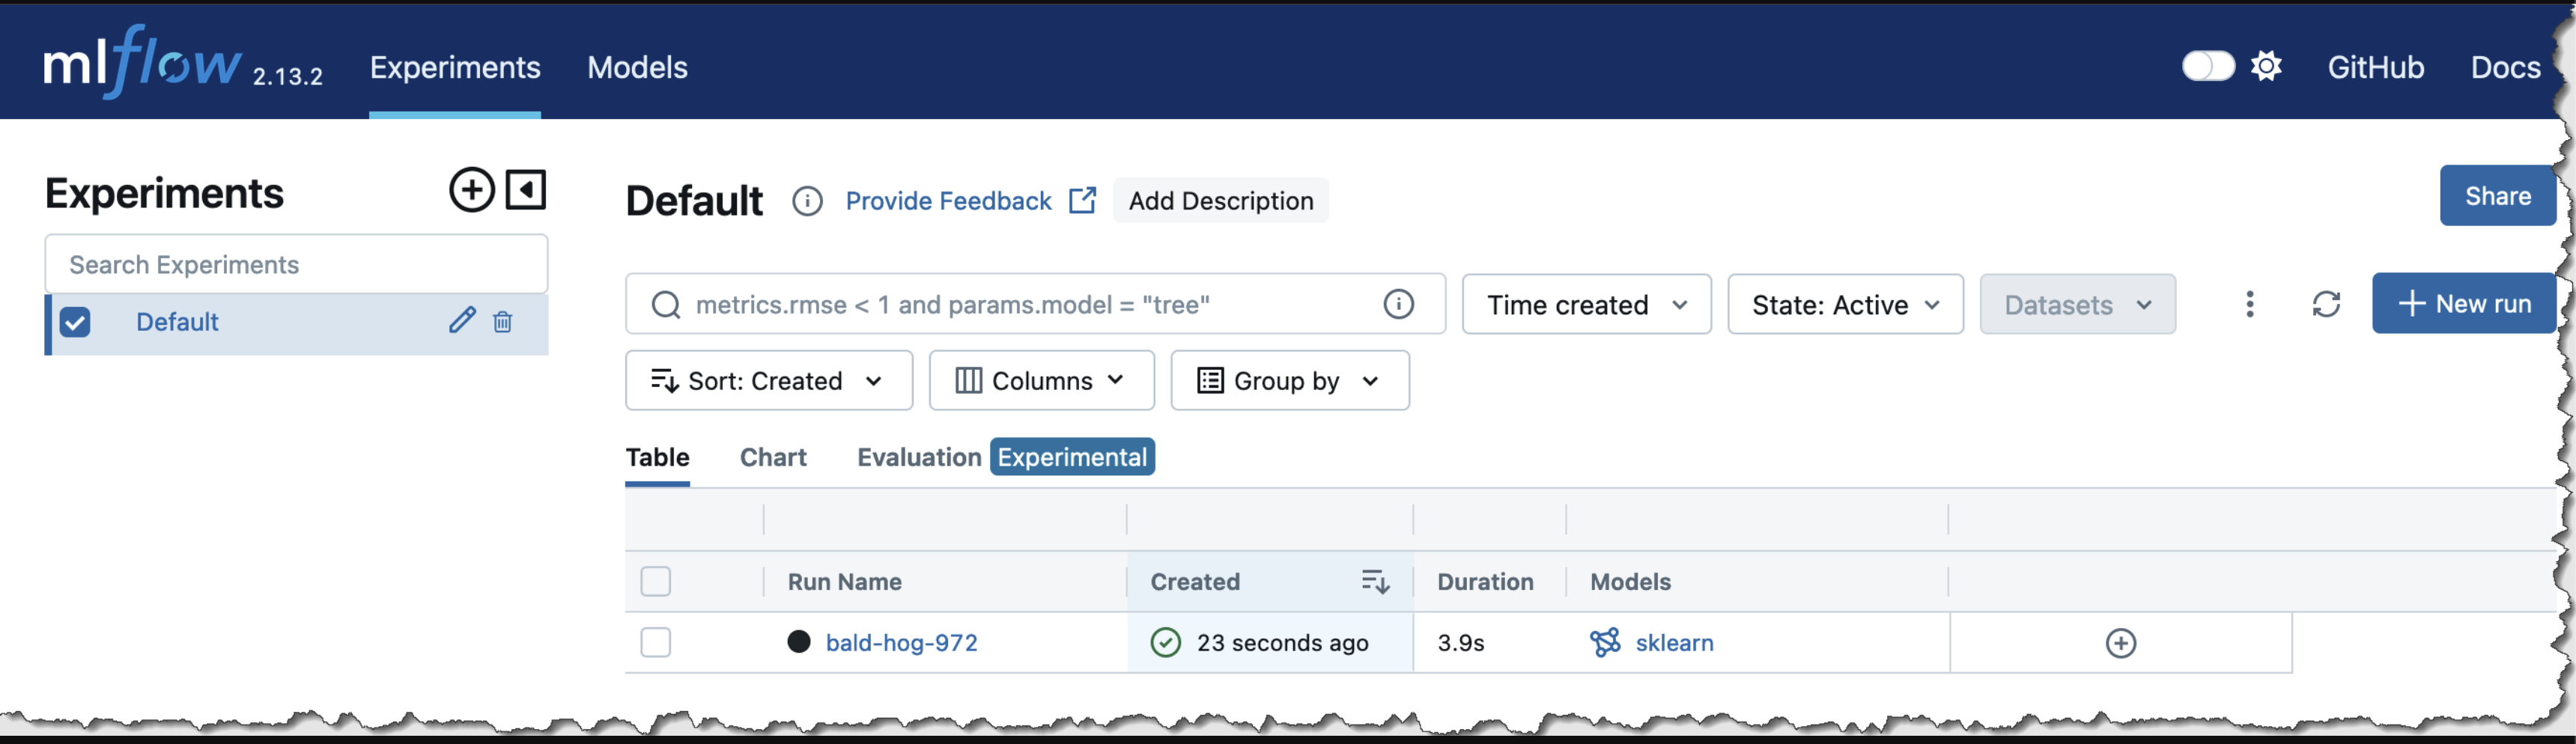

You can choose to include MLflow as a part of your training workflow to track your model fine-tuning metrics in realtime by simply specifying a **mlflow** tracking arn.

Optionally you can also report to 
1. **tensorboard**
2. **wandb**.

In [ ]:
MLFLOW_TRACKING_SERVER_ARN = None # or "arn:aws:sagemaker:us-west-2:<account-id>:mlflow-tracking-server/<server-name>"

if MLFLOW_TRACKING_SERVER_ARN:
    reports_to = "mlflow"
else:
    reports_to = "tensorboard"

In [ ]:
NUM_GPUS = 8
job_name = 'gpt-oss-finetuning'
training_instance_type = "ml.g5.2xlarge"

In [ ]:
if MLFLOW_TRACKING_SERVER_ARN:
    training_env = {
        "MLFLOW_EXPERIMENT_NAME": "openai-gpt-oss-20b-peft",
        "MLFLOW_TAGS": '{"source.job": "sm-training-jobs", "source.type": "sft", "source.framework": "pytorch"}',
        "HF_TOKEN": hf_token,
        "MLFLOW_TRACKING_URI": MLFLOW_TRACKING_SERVER_ARN,
    }
else:
    training_env = {
        "HF_TOKEN": hf_token
    }


**Training Using `PyTorch` Estimator**
Leverages the official PyTorch SageMaker container to run a custom training script using the Accelerate and DeepSpeed libraries. This option is ideal for users who want full control over the training pipeline and de


#### Using `PyTorch` Estimator

In [ ]:
pytorch_estimator = PyTorch(
    image_uri=f"763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-training:2.7.1-gpu-py312-cu128-ubuntu22.04-sagemaker",
    entry_point="accelerate_sagemaker_train.sh", # Adapted bash script to train using accelerate on SageMaker - Multi-GPU
    source_dir="code",
    instance_type=training_instance_type,
    instance_count=1,
    base_job_name=f"{job_name}-pytorch",
    role=role,
    volume_size=300,
    py_version="py312",
    keep_alive_period_in_seconds=3600,
    environment=training_env,
    hyperparameters={
        "num_process": NUM_GPUS,
        "config": "recipes/openai--gpt-oss-20b-Vanilla-MXFP4.yaml"
    }
)


In [ ]:
# fit or train
pytorch_estimator.fit({"training": uploaded_s3_uri}, wait=False)

In [ ]:
s3_model_data_uri = pytorch_estimator.model_data

At the end of a training session, finetuned model/adapters are stored on S3, pull the model weights for deployment.

In [ ]:
s3_model_data_uri = huggingface_estimator.model_data